## DEMO ResNet 

We recommend starting with the notebook MLP in the directori DEMO/MLP/.

So far the convolutional layers on which the neurons are added, have to be : 
* kernel_size = 3 
* ((padding = 1, , stride = 1) or (padding = 'same')) 

In [1]:
import sys
sys.path.append('../../TINY/')

In [2]:
import TINY
import UTILS
import SOLVE_EB as EB
import GLOBALS as G
from mes_imports import *
import load_data_Loader


## Starting architecture

A skip connection is defined by a couple $(i_{in}, i_{out})$ and a transformation skip_fct[$i_{in}$].
It transforms the activity of layer $i_{in}$ with the function skip_fct[$i_{in}$] and adds it the the pre-activation of layer $i_{out} + 1$.

Currently multiple skip connections starting from $i_{in}$ is not supported.



In [3]:
G.reduction = 64
G.rescale = 'theta' 
G.lr = 1e-2
G.batch_size = 32
G.architecture_growth = 'Our' 
G.lambda_method = 1e-3
nbr_epochs_betw_adding = 0.25

from settings import starting_architecture_RN18 as starting_architecture

In [4]:
skip_connections = starting_architecture.skip_connections_RN18
for (i, j) in zip(skip_connections['in'], skip_connections['out']) :
    print('skip connection between layer', i, ' and ', j)

skip connection between layer 2  and  3
skip connection between layer 4  and  5
skip connection between layer 7  and  8
skip connection between layer 9  and  10
skip connection between layer 12  and  13
skip connection between layer 14  and  15
skip connection between layer 17  and  18
skip connection between layer 19  and  20


The transformation computed by each skip connection is described with the dictionnary skip_fct with its keys {$i_{in}$ for $i_{in} \ in$ skip_connections['in']}. 

If the key $i_{in}$ doesn't existst, the identity will performed as the default transformation. In this notebook we choose the identity for all the skip connections,  so the dictionnary skip_fct is empty.

In [5]:
skip_fct = starting_architecture.skip_fct_RN18
skip_fct.keys()

dict_keys([])

We start with an architecture such that each layer between a skip connection is of size 1/64 the usual size of ResNet18.

In [6]:
skeleton = starting_architecture.skeleton_RN18
layer_name = starting_architecture.layer_name_RN18

print('Reduction is :', G.reduction)
print('depth  |  layer type | in_chan->out_chan / output size')
for k in sorted(list(skeleton.keys()))[1:] :
    if layer_name[k][0] == 'C' :
        print('depth ' + str(k) + ' |  Conv | ' + str(skeleton[k]['in_channels']) + ' -> ' + str(skeleton[k]['out_channels']))
        #print('depth ' + str(k) + ' |  Conv | ' + str(RN.outputs_size_after_activation[k]))
    else :
        print('depth ' + str(k) + ' | Linear | ' + str(skeleton[k]['size']))
        #print('depth ' + str(k) + ' | Linear | ' + str(RN.outputs_size_after_activation[k]))

Reduction is : 64
depth  |  layer type | in_chan->out_chan / output size
depth 1 |  Conv | 3 -> 64
depth 2 |  Conv | 64 -> 1
depth 3 |  Conv | 1 -> 64
depth 4 |  Conv | 64 -> 1
depth 5 |  Conv | 1 -> 64
depth 6 |  Conv | 64 -> 128
depth 7 |  Conv | 128 -> 2
depth 8 |  Conv | 2 -> 128
depth 9 |  Conv | 128 -> 2
depth 10 |  Conv | 2 -> 128
depth 11 |  Conv | 128 -> 256
depth 12 |  Conv | 256 -> 4
depth 13 |  Conv | 4 -> 256
depth 14 |  Conv | 256 -> 4
depth 15 |  Conv | 4 -> 256
depth 16 |  Conv | 256 -> 512
depth 17 |  Conv | 512 -> 8
depth 18 |  Conv | 8 -> 512
depth 19 |  Conv | 512 -> 8
depth 20 |  Conv | 8 -> 512
depth 21 | Linear | 100


The activitation functions are stored in fct.

In [7]:
fct = starting_architecture.fct_RN18
for k in sorted(list(fct.keys())) :
    print('fct_', k, ' := ', fct[k])

fct_ 1  :=  ReLU()
fct_ 2  :=  ReLU()
fct_ 3  :=  ReLU()
fct_ 4  :=  ReLU()
fct_ 5  :=  ReLU()
fct_ 6  :=  AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
fct_ 7  :=  ReLU()
fct_ 8  :=  ReLU()
fct_ 9  :=  ReLU()
fct_ 10  :=  ReLU()
fct_ 11  :=  AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
fct_ 12  :=  ReLU()
fct_ 13  :=  ReLU()
fct_ 14  :=  ReLU()
fct_ 15  :=  ReLU()
fct_ 16  :=  AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
fct_ 17  :=  ReLU()
fct_ 18  :=  ReLU()
fct_ 19  :=  ReLU()
fct_ 20  :=  AdaptiveAvgPool2d(output_size=(1, 1))
fct_ 21  :=  Identity()


In [8]:
a, b, c, d = starting_architecture.a, starting_architecture.b, starting_architecture.c, starting_architecture.d
a0, b0, c0, d0 = starting_architecture.a0, starting_architecture.b0, starting_architecture.c0, starting_architecture.d0
ainf, binf, cinf, dinf = starting_architecture.ainf, starting_architecture.binf, starting_architecture.cinf, starting_architecture.dinf


In [9]:
print('architecture growth from ', (a0, b0, c0, d0) , 'to', (a, b, c, d))

architecture growth from  (1, 2, 4, 8) to (64, 128, 256, 512)


## The adding strategy

In this notebook the startegy is to add neurons at each layer until it reachs the architecture of the usual RN18. The amount of neurons to add at each depth to achieve this results is in the dictionnary to_add.

In [11]:
to_add = {2 : (ainf - a0), 4 : (ainf - a0), 7 : (binf - b0), 9 : (binf - b0), 
          12 : (cinf - c0), 14 : (cinf - c0), 17 : (dinf - d0), 19 : (dinf - d0)}
to_add

{2: 63, 4: 63, 7: 126, 9: 126, 12: 252, 14: 252, 17: 504, 19: 504}

## The model RN

In [12]:
dico_parameters = {
                    'skeleton' : copy.deepcopy(skeleton),
                    'Loss' : UTILS.Loss_entropy,
                    'fct' : fct,
                    'layer_name' :layer_name,
                    'init_deplacement' : 1e-8,
                    'batch_size' : G.batch_size,
                    'lr' : G.lr,
                    'rescale' : G.rescale,
                    'exp' : 2,
                    'lambda_method' : G.lambda_method,
                    'accroissement_decay' : 1e-8,
                    'lu_conv' : 0.001,
                    'max_batch_estimation' : 100,
                    'max_amplitude' : 20.,
                    'ind_lmbda_shape' : 1000,
                    'init_X_shape' : [3, 32, 32],
                    'skip_connections' : skip_connections,
                    'skip_fcts' : skip_fct,
                    'len_train_dataset' : 50000,
                    'len_test_dataset' : 10000,
                    'T_j_depth' : [d for d in list(to_add.keys()) if layer_name[d][0] == 'C'],
                    'selection_neuron' : UTILS.selection_neuron_seuil,
                    'how_to_define_batchsize' : UTILS.indices_non_constant, 
                    'depth_seuil' : starting_architecture.depth_seuil,
                    'architecture_growth' : G.architecture_growth
                    }
RN = TINY.TINY(dico_parameters)

RN.training_data, RN.test_data = load_data_Loader.load_database_CIFAR100(AugD=True)
RN.tr_loader = DataLoader(RN.training_data, batch_size=RN.max_batch_estimation, shuffle=True)
RN.te_loader = DataLoader(RN.test_data, batch_size=RN.max_batch_estimation, shuffle=True)

Computing matrix T at depth :  2  ...


/home/tau/mverbock/TINYpub/DEMO/ResNet/../../TINY/T_S_F_N.py:137: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343964576/work/aten/src/ATen/SparseCsrTensorImpl.cpp:54.)
  T_T_T = torch.sparse.sum(torch.cat([torch.unsqueeze(torch.sparse.mm(T_j[k].transpose(1, 0), T_j[k]), dim = 0) for k in range(T_j.shape[0])]), dim = 0)


Computing matrix T at depth :  4  ...
Computing matrix T at depth :  7  ...
Computing matrix T at depth :  9  ...
Computing matrix T at depth :  12  ...
Computing matrix T at depth :  14  ...
Computing matrix T at depth :  17  ...
Computing matrix T at depth :  19  ...
Files already downloaded and verified
Files already downloaded and verified


The starting architecture is then :

In [13]:
print('depth  |  layer type | output size')
for k in sorted(list(skeleton.keys()))[1:] :
    if layer_name[k][0] == 'C' :
        #print('depth ' + str(k) + ' |  Conv | ' + str(skeleton[k]['in_channels']) + ' -> ' + str(skeleton[k]['out_channels']))
        print('depth ' + str(k) + ' |  Conv | ' + str(RN.outputs_size_after_activation[k]))
    else :
        #print('depth ' + str(k) + ' | Linear | ' + str(skeleton[k]['size']))
        print('depth ' + str(k) + ' | Linear | ' + str(RN.outputs_size_after_activation[k]))

depth  |  layer type | output size
depth 1 |  Conv | [32, 32, 64]
depth 2 |  Conv | [32, 32, 1]
depth 3 |  Conv | [32, 32, 64]
depth 4 |  Conv | [32, 32, 1]
depth 5 |  Conv | [32, 32, 64]
depth 6 |  Conv | [16, 16, 128]
depth 7 |  Conv | [16, 16, 2]
depth 8 |  Conv | [16, 16, 128]
depth 9 |  Conv | [16, 16, 2]
depth 10 |  Conv | [16, 16, 128]
depth 11 |  Conv | [8, 8, 256]
depth 12 |  Conv | [8, 8, 4]
depth 13 |  Conv | [8, 8, 256]
depth 14 |  Conv | [8, 8, 4]
depth 15 |  Conv | [8, 8, 256]
depth 16 |  Conv | [4, 4, 512]
depth 17 |  Conv | [4, 4, 8]
depth 18 |  Conv | [4, 4, 512]
depth 19 |  Conv | [4, 4, 8]
depth 20 |  Conv | [1, 1, 512]
depth 21 | Linear | [100]


## Architecture growth and training 

In [14]:
df_tracker = pd.DataFrame()
A_tr, A_te, L_tr, L_te, T = np.array([]), np.array([]), np.array([]), np.array([]), np.array([0])
nbr_pass = 8

path = 'resultats/'

In [15]:
def update_quantity_of_interest() :
        global L_tr, L_te, A_tr, A_te, T, df_tracker
        dico_tracker = {'vps' + str(i) : [ RN.valeurs_propres[i].item()] for i in range(len(RN.valeurs_propres))}

        dico_tracker.update({'depth_add' : best_depth, 'nbr_added_neuron': RN.nbr_added_neuron})
        dico_tracker.update({'accroissement' : [dico_EB[best_depth]['accroissement']], 'portion_gain' : [dico_EB[best_depth]['portion_gain']],
                            'nbr_parameters_apres' : [RN.count_parameters()], 'nbr_parameters_avant' : [nbr_parameters_avant],
                            'T' : [T[-1]], 'len_L_tr' : [len(L_tr)], 'lu_conv' : [RN.lu_conv]})

        df_tracker = pd.concat([df_tracker, pd.DataFrame.from_dict(dico_tracker)], ignore_index=True)

        L_tr = np.concatenate([L_tr, l_tr])
        L_te = np.concatenate([L_te, l_te])
        A_tr = np.concatenate([A_tr, a_tr])
        A_te = np.concatenate([A_te, a_te])
        T = np.concatenate([T, t +  T[-1]])

def stabilize_training() :
    RN.batch_size = math.ceil(np.sqrt(RN.count_parameters() / nbr_parameters_avant) *  RN.batch_size)
    #RN.batch_size = math.ceil(RN.count_parameters() / nbr_parameters_avant *  RN.batch_size)


In [16]:
count = 1

In [17]:
for pas in range(nbr_pass) :
    size_to_add = len(to_add.keys())
    #size_to_add = 1
    for j in tqdm(range(size_to_add)) :
        nbr_parameters_avant = RN.count_parameters()
        ########### Select the best depth (time consuming)############
        #gc.collect()
        #torch.cuda.empty_cache()
        #RN.tr_loader = DataLoader(RN.training_data, batch_size=RN.max_batch_estimation, shuffle=True)
        #RN.te_loader = DataLoader(RN.test_data, batch_size=RN.max_batch_estimation, shuffle=True)

        #depth_ajout = list(to_add.keys())
        #depth_in_decreasing_criterion, dico_EB = EB.where_is_EB_best_solved(RN, depths = depth_ajout)

        #best_depth = depth_in_decreasing_criterion[0]
        #dico_EB_bd = dico_EB[best_depth]
        #alpha, omega, bias_alpha, vps = dico_EB_bd['alpha'], dico_EB_bd['omega'], dico_EB_bd['bias_alpha'], dico_EB_bd['vps']
        #lambda_method = dico_EB_bd['beta_min']

        #RN.alpha, RN.omega, RN.bias_alpha, RN.valeurs_propres = None, None, None, []
        #RN.TAB_Add = None

        #if dico_EB_bd['accroissement'] > 0 :
        #    RN.dico_w, RN.lambda_method = dico_EB_bd['dico_w'], dico_EB_bd['beta_min']
        #    EB.add_neurons(RN, best_depth, alpha = alpha, omega = omega, bias_alpha = bias_alpha, valeurs_propres = vps)
        #    RN.lambda_method = torch.tensor(0., device = my_device_0)

        #    to_add[best_depth] -= alpha.shape[0]
        #    if to_add[best_depth] == 0 :
        #        del to_add[best_depth]
        
        
        ######## Or just add neurons in depth order (fast) ######
        k = list(to_add.keys())[j]
        best_depth, dico_EB = k, {k : {'accroissement' : 0., 'portion_gain' : 0}}
        RN.dico_w = None
        RN.how_to_define_batchsize(RN, k + 1, method = 'NG')
        EB.compute_NG(RN, k + 1, update = False, compute_gain = False)
        RN.how_to_define_batchsize(RN, k, method = 'Add')
        EB.add_neurons(RN, k, update = True)
        to_add[k] -= RN.alpha.shape[0] 
        
        
        

        #### training loop ####
        stabilize_training()
        RN.tr_loader = DataLoader(RN.training_data, batch_size=RN.batch_size, shuffle=True)
        RN.te_loader = DataLoader(RN.test_data, batch_size=RN.batch_size, shuffle=True)
        optimizer = torch.optim.SGD(RN.parameters(), lr = RN.lr)
        l_tr, l_te, l_va, a_tr, a_te, a_va, t = RN.train_batch(nbr_epochs_betw_adding, optimizer = optimizer)
        update_quantity_of_interest()


        df_performance = pd.DataFrame.from_dict({'L_tr' : L_tr, 'L_te' : L_te, 'A_tr' : A_tr, 'A_te' : A_te, 'T' : T[1:]})
        df_tracker.to_csv( path + 'df_tracker.csv' , index=False)
        df_performance.to_csv( path + '/df_performance.csv', index=False)
        RN.T = T[-1]
        RN.len_L_tr = len(L_tr)

    UTILS.save_model_to_file(RN, path = path + '/' , name='model_' + str(count))
    count += 1


  0%|          | 0/1 [00:00<?, ?it/s]



*** started  NG at  3 ***
Batch size for estimation : 200


*** started  Add at  2 ***
Batch size for estimation : 200
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
***  normalize NewNeurons acc. ||parameters|| ***
amplitude factor for the new neurons : 0.0010000000474974513
(alpha, omega) <-- (sqrt(ampl) x alpha, sqrt(ampl) x omega)
*** Added neurons at  2 ***




  0%|          | 0/1 [00:00<?, ?it/s]



*** started  NG at  3 ***
Batch size for estimation : 200


*** started  Add at  2 ***
Batch size for estimation : 200
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
***  normalize NewNeurons acc. ||parameters|| ***
amplitude factor for the new neurons : 0.0010000000474974513
(alpha, omega) <-- (sqrt(ampl) x alpha, sqrt(ampl) x omega)
*** Added neurons at  2 ***




  0%|          | 0/1 [00:00<?, ?it/s]



*** started  NG at  3 ***
Batch size for estimation : 200


*** started  Add at  2 ***
Batch size for estimation : 200
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
***  normalize NewNeurons acc. ||parameters|| ***
amplitude factor for the new neurons : 0.0010000000474974513
(alpha, omega) <-- (sqrt(ampl) x alpha, sqrt(ampl) x omega)
*** Added neurons at  2 ***




KeyboardInterrupt: 

## Plots

In [60]:
df_tracker = pd.read_csv(path + 'df_tracker.csv')
df_performance = pd.read_csv(path + 'df_performance.csv')

In [61]:
coef = 100 # smoothing coefficient 
kernel = torch.zeros(1, 1, coef)
C = 10
for i, t1 in enumerate(torch.linspace(-C, C, coef)[:int(coef/2) + 1]) :
    t2 = t1 + 2*C/(coef/2)
    #if t1 <= 0 :
    h = torch.distributions.normal.Normal(0, 1).cdf(t2) - torch.distributions.normal.Normal(0, 1).cdf(t1)
    kernel[0, 0, i] = h
kernel /= kernel.sum()

In [62]:
A_tr_padd = torch.concatenate([torch.ones(int(coef/2)) * df_performance['A_tr'][:5].mean(), 
                               torch.from_numpy(df_performance['A_tr'].values.astype(np.float32)),
                               torch.ones(int(coef/2)) * df_performance['A_tr'][-5:].mean()])
A_te_padd = torch.concatenate([torch.ones(int(coef/2)) * df_performance['A_te'][:5].mean(), 
                               torch.from_numpy(df_performance['A_te'].values.astype(np.float32)),
                               torch.ones(int(coef/2)) * df_performance['A_te'][-5:].mean()])
smooth_A_tr = torch.nn.functional.conv1d(A_tr_padd[None, None, :], kernel, padding = 0)
smooth_A_te = torch.nn.functional.conv1d(A_te_padd[None, None, :], kernel, padding = 0)

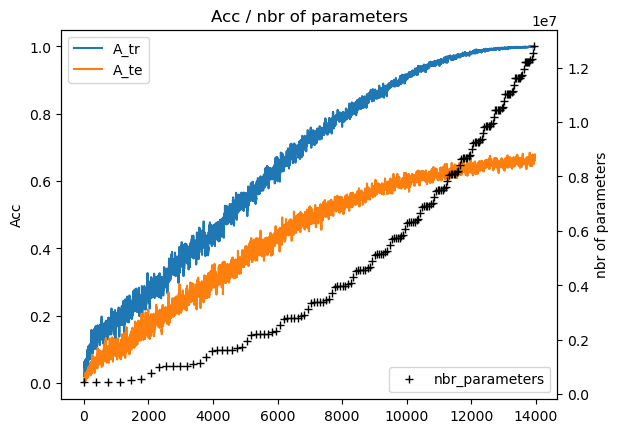

In [63]:
fig, ax = plt.subplots(1, 1)
ax.plot(smooth_A_tr[0, 0], label = 'A_tr')
ax.plot(smooth_A_te[0, 0], label = 'A_te')

ax.legend()
ax_nbrp = ax.twinx()
ax_nbrp.plot(df_tracker['len_L_tr'], df_tracker['nbr_parameters_apres'], '+', label = 'nbr_parameters', color = 'black')
ax_nbrp.legend(loc = 'lower right')
ax.set_title('Acc / nbr of parameters')
ax.set_ylabel('Acc')
ax_nbrp.set_ylabel('nbr of parameters')
plt.show()

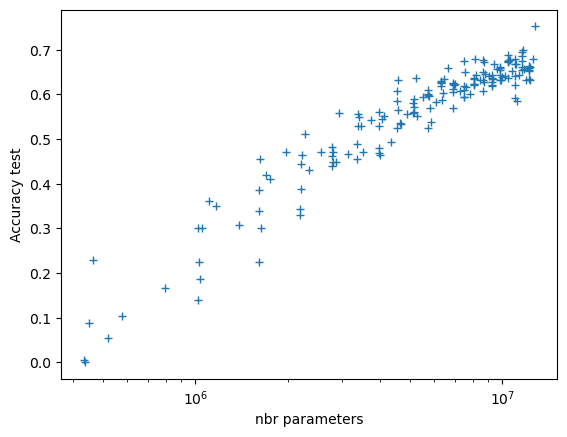

In [64]:
plt.plot(df_tracker['nbr_parameters_apres'], A_te_padd[df_tracker['len_L_tr'].values], '+')
plt.xlabel('nbr parameters')
plt.ylabel('Accuracy test')
plt.xscale('log')
plt.show()

In [10]:
df_tracker

,Unnamed: 0,vps0,vps1,vps2,vps3,vps4,vps5,vps6,vps7,vps8,...,vps23,depth_add,nbr_added_neuron,accroissement,portion_gain,nbr_parameters_apres,nbr_parameters_avant,T,len_L_tr,lu_conv
0,0,0.024471,0.021132,0.019659,0.018439,0.017467,0.016562,0.015765,0.014933,0.014206,...,0.008816,19,24,0.090533,0.664,650822,429566,0.000000,0,0.001
1,0,0.053013,0.048903,0.038659,0.033937,0.030980,0.029312,0.026862,0.026536,0.024432,...,0.015070,17,24,0.039019,0.633,872078,650822,20.577017,313,0.001
2,0,0.018107,0.017103,0.015909,0.015567,0.014988,0.014588,0.014084,0.013802,0.013313,...,0.010031,19,24,0.025497,0.600,1093334,872078,40.208526,579,0.001
3,0,0.014327,0.013892,0.013219,0.012724,0.012373,0.012339,0.012019,0.011765,0.011635,...,0.009279,19,24,0.022836,0.584,1314590,1093334,59.394008,815,0.001
4,0,0.058541,0.049718,0.046374,0.044468,0.042250,0.039763,0.037756,0.033531,0.033054,...,0.022038,17,24,0.016738,0.565,1535846,1314590,77.660275,1027,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,0,0.024035,0.021356,0.020226,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2,3,0.001298,0.555,12676262,12672797,2833.891716,11554,0.001
164,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,7,0,0.000000,1.000,12676262,12676262,2854.088870,11595,0.001
165,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,7,0,0.000000,1.000,12676262,12676262,2874.309621,11636,0.001
166,0,0.059216,0.050403,0.043686,0.036952,0.036151,0.034637,NaN,NaN,NaN,...,NaN,7,6,0.000867,0.490,12690104,12676262,2894.702185,11677,0.001
